# Miniproyecto 2: Predicción del precio y clasificación de autos usados

**Created:** 2025-08-11

En este notebook se encuentran las siguientes sesiones: 
- Sección 1. Carga y exploración de los datos.
- Sección 2. Ingeniería de características (HighDemand)
- Sección 3. Modelos:
- Definición de pipelines 
- GridSearchCV con validación cruzada
- Sección 4. Evaluación con métricas y gráficas. 
- Sección 5. Conclusiones


## 1) Sección 1. Carga y exploración de datos

## Instalación de paquetes

In [1]:
%pip install -q --disable-pip-version-check kagglehub pandas numpy scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


## Imports & config

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.model_selection import (
    train_test_split, StratifiedShuffleSplit, GridSearchCV, KFold, StratifiedKFold
)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, RocCurveDisplay
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print('Python:', sys.version.split()[0])
import sklearn
print('pandas:', pd.__version__)
print('scikit-learn:', sklearn.__version__)

Python: 3.9.23
pandas: 2.3.1
scikit-learn: 1.6.1


## Parámetros

In [3]:
TOTAL_SUBSET = 20_000
CHUNK_SIZE = 150_000
ROW_CAP    = 200_000

USE_THESE = [
    'id','url','region','region_url','price','year','manufacturer','model','condition','cylinders',
    'fuel','odometer','title_status','transmission','VIN','drive','size','type','paint_color',
    'image_url','description','county','state','lat','long','posting_date'
]

## Carga de datos

In [4]:
# import kagglehub
# path = kagglehub.dataset_download("austinreese/craigslist-carstrucks-data")

DATA_PATH = None
try:
    if 'path' in globals():
        DATA_PATH = str(next(Path(path).rglob("vehicles.csv")))
except Exception:
    DATA_PATH = None

if DATA_PATH is None:
    # Set your local path here if needed
    DATA_PATH = r"C:\Users\Laura\.cache\kagglehub\datasets\austinreese\craigslist-carstrucks-data\versions\10\vehicles.csv"

print("DATA_PATH:", DATA_PATH)

DATA_PATH: C:\Users\Laura\.cache\kagglehub\datasets\austinreese\craigslist-carstrucks-data\versions\10\vehicles.csv


## 2) Ingeniería de características (HighDemand)

## Limpieza preliminar de datos y creación de la variable binaria: HighDemand
Transformación de la variable *cylinders* a *cylinders_num*

In [5]:
def _read_header_cols(p):
    return pd.read_csv(p, nrows=0, engine='python', on_bad_lines='skip',
                       encoding='utf-8', encoding_errors='ignore').columns.tolist()

orig_cols = _read_header_cols(DATA_PATH)

# Global price median (first pass)
price_parts = []
for ch in pd.read_csv(
    DATA_PATH, usecols=lambda c: c=='price',
    engine='python', on_bad_lines='skip',
    encoding='utf-8', encoding_errors='ignore',
    chunksize=CHUNK_SIZE
):
    price_parts.append(pd.to_numeric(ch.get('price'), errors='coerce'))
price_median_global = pd.concat(price_parts, ignore_index=True).median(skipna=True)
print("Global median(price):", float(price_median_global))

# Second pass
parts, total = [], 0
for ch in pd.read_csv(
    DATA_PATH,
    engine='python', on_bad_lines='skip',
    encoding='utf-8', encoding_errors='ignore',
    chunksize=CHUNK_SIZE
):
    keep = [c for c in USE_THESE if c in ch.columns]
    ch = ch[keep].copy()

    for c in ['price','year','odometer','lat','long']:
        if c in ch.columns:
            ch[c] = pd.to_numeric(ch[c], errors='coerce')

    if 'cylinders' in ch.columns:
        ch['cylinders_num'] = ch['cylinders'].astype(str).str.extract(r'(\d+)').astype(float)

    ch = ch[(ch['price'] > 0)]
    if 'year' in ch.columns:
        ch = ch[(ch['year'].isna()) | ((ch['year'] >= 1990) & (ch['year'] <= 2025))]

    ch['HighDemand'] = (ch['price'] > price_median_global).astype('int8')

    parts.append(ch)
    total += len(ch)
    if ROW_CAP is not None and total >= ROW_CAP:
        break

df = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()
print("Loaded df:", df.shape)
df.head()

KeyboardInterrupt: 

## Exploración de datos - Price

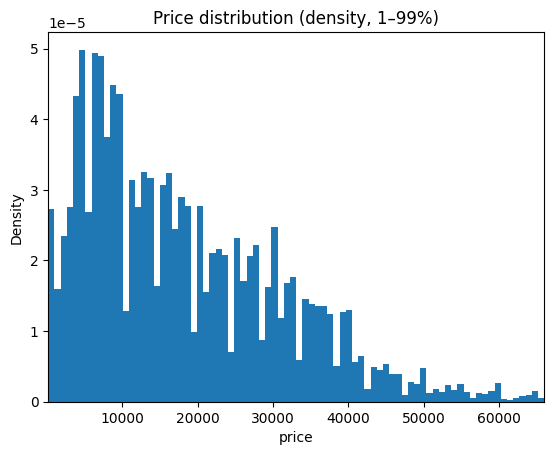

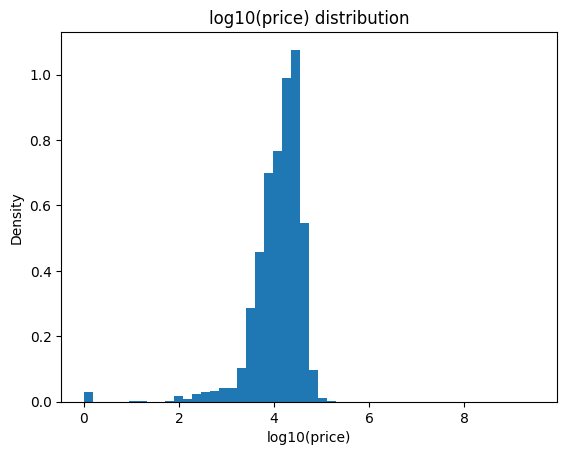

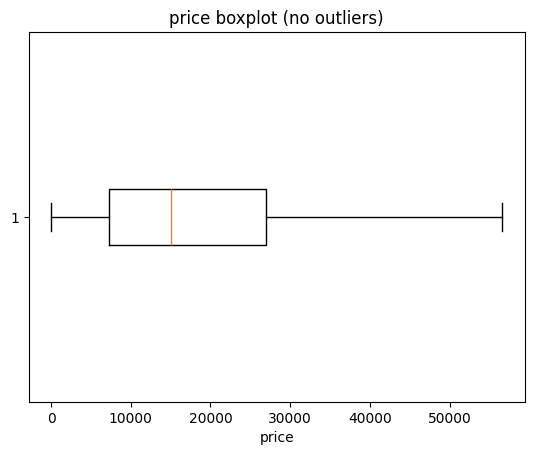

In [6]:
s = pd.to_numeric(df['price'], errors='coerce').dropna()

# Density hist (1–99%)
plt.figure()
lo, hi = s.quantile([0.01, 0.99])
plt.xlim(lo, hi)
plt.hist(s[(s>=lo)&(s<=hi)], bins=80, density=True)
plt.title('Price distribution (density, 1–99%)')
plt.xlabel('price'); plt.ylabel('Density')
plt.show()

# Log10 hist
s_pos = s[s > 0]
plt.figure()
plt.hist(np.log10(s_pos), bins=50, density=True)
plt.title('log10(price) distribution')
plt.xlabel('log10(price)'); plt.ylabel('Density')
plt.show()

# Boxplot without fliers
plt.figure()
plt.boxplot(s, vert=False, showfliers=False)
plt.title('price boxplot (no outliers)')
plt.xlabel('price')
plt.show()

De la primera gráfica, se tiene que la distribución de price está claramente sesgada a la derecha: la mayor concentración de autos se ubica entre los 5000 y 15000 USD, y la frecuencia disminuye conforme sube el precio, dejando una cola larga que alcanza valores por encima de 60000 USD. Se observan pequeños picos locales, coherentes con distintos segmentos del mercado.

En la segunda gráfica, al tomar log10(price) la distribución se vuelve mucho más simétrica y casi gaussiana, concentrada alrededor de 4 a 4.4 en log10, es decir, precios de decenas de miles (aprox. 10000–25000). La transformación reduce la cola derecha que se da en escala original y deja unos pocos valores atípicos muy bajos (log10 < 3, precios de pocos miles)

Finalmente, el boxplot (sin atípicos dibujados) confirma una asimetría positiva: la mediana ronda los 15000 USD, con el 50 % central entre aproximadamente 8000 y 26000 - 28000. El bigote derecho es mucho más largo que el izquierdo y llega cerca de ~55–60 k, reflejando la cola larga de precios altos; el izquierdo cae hacia valores cercanos a 1000 y 2000, se tiene entonces mucha concentración en rangos medios-bajos y pocos autos muy caros que alargan la cola.



## Subset de 20000 datos y splits (Training - Testing)

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

categorical_features = ['manufacturer','model','type','transmission','fuel','drive','condition','size','state','region']
numeric_features     = ['year','cylinders_num','odometer']

categorical_features = [c for c in categorical_features if c in df.columns]
numeric_features     = [c for c in numeric_features if c in df.columns]

X_full = df[categorical_features + numeric_features].copy()
y_full_price = df['price'].copy()
y_full_hd    = df['HighDemand'].astype('int8').copy()

TOTAL = min(TOTAL_SUBSET, len(X_full))
if y_full_hd.nunique() > 1:
    sss = StratifiedShuffleSplit(n_splits=1, train_size=TOTAL, random_state=RANDOM_STATE)
    idx, _ = next(sss.split(X_full, y_full_hd))
    X_small = X_full.iloc[idx].reset_index(drop=True)
    y_price_small = y_full_price.iloc[idx].reset_index(drop=True)
else:
    X_small = X_full.sample(n=TOTAL, random_state=RANDOM_STATE)
    y_price_small = y_full_price.loc[X_small.index].reset_index(drop=True)

print("Subset:", X_small.shape)

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_small, y_price_small, test_size=0.2, random_state=RANDOM_STATE
)

med_train = y_train_reg.median()
y_train_clf = (y_train_reg > med_train).astype('int8')
y_test_clf  = (y_test_reg  > med_train).astype('int8')

X_train_clf, X_test_clf = X_train_reg.copy(), X_test_reg.copy()

print("Train shapes:", X_train_reg.shape, X_train_clf.shape)
print("Median(train) =", float(med_train))

Subset: (20000, 13)
Train shapes: (16000, 13) (16000, 13)
Median(train) = 14999.0


## 3) Sección 3. Modelos
En esta sección, en primer lugar se desarrolla lo correspondiente a los modelos de regresión: Ridge y Lasso y de clasificación con regresión logística, posteriormente se ejecuta knn para regresión y para clasificación. 

## Preprocesamiento (imputación de datos + OHE + scaler)
    

In [8]:
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('ohe', ohe)])
num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])

preprocess = ColumnTransformer([('cat', cat_pipe, categorical_features),
                                ('num', num_pipe, numeric_features)])

## Pipelines & GridSearchCV
Ridge, Lasso, Regresión logística

In [9]:
ridge_pipe = Pipeline([('preprocess', preprocess), ('model', Ridge(random_state=RANDOM_STATE))])
lasso_pipe = Pipeline([('preprocess', preprocess), ('model', Lasso(random_state=RANDOM_STATE, max_iter=10000))])
logreg_pipe = Pipeline([('preprocess', preprocess), ('model', LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))])

ridge_grid = {'model__alpha': np.logspace(-2, 2, 5)}
lasso_grid = {'model__alpha': np.logspace(-2, 2, 5)}
logreg_grid = {'model__C': np.logspace(-2, 2, 5), 'model__penalty': ['l2'], 'model__solver': ['lbfgs']}

cv_reg = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
cv_clf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

ridge_search = GridSearchCV(ridge_pipe, ridge_grid, cv=cv_reg, scoring='neg_mean_absolute_error', n_jobs=1, verbose=2)
lasso_search = GridSearchCV(lasso_pipe, lasso_grid, cv=cv_reg, scoring='neg_mean_absolute_error', n_jobs=1, verbose=2)
logreg_search = GridSearchCV(logreg_pipe, logreg_grid, cv=cv_clf, scoring='f1', n_jobs=1, verbose=2)

## Training
Ridge, Lasso, Regresión logística

In [10]:
import time
t0=time.time(); ridge_search.fit(X_train_reg, y_train_reg); print("Ridge in", round(time.time()-t0,1),"s")
t0=time.time(); lasso_search.fit(X_train_reg, y_train_reg); print("Lasso in", round(time.time()-t0,1),"s")
t0=time.time(); logreg_search.fit(X_train_clf, y_train_clf); print("LogReg in", round(time.time()-t0,1),"s")

print('Best Ridge:', ridge_search.best_params_, '=> MAE_cv:', -ridge_search.best_score_)
print('Best Lasso:', lasso_search.best_params_, '=> MAE_cv:', -lasso_search.best_score_)
print('Best LogReg:', logreg_search.best_params_, '=> F1_cv:',  logreg_search.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ..................................model__alpha=0.01; total time=   5.4s
[CV] END ..................................model__alpha=0.01; total time=   3.5s
[CV] END ..................................model__alpha=0.01; total time=   3.3s
[CV] END ...................................model__alpha=0.1; total time=   2.8s
[CV] END ...................................model__alpha=0.1; total time=   3.0s
[CV] END ...................................model__alpha=0.1; total time=   3.2s
[CV] END ...................................model__alpha=1.0; total time=   2.7s
[CV] END ...................................model__alpha=1.0; total time=   2.8s
[CV] END ...................................model__alpha=1.0; total time=   3.3s
[CV] END ..................................model__alpha=10.0; total time=   3.1s
[CV] END ..................................model__alpha=10.0; total time=   3.0s
[CV] END ..................................model_

c:\Users\Laura\miniconda3\envs\ml_cpuenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.030e+10, tolerance: 4.220e+08
  model = cd_fast.enet_coordinate_descent(


[CV] END ..................................model__alpha=0.01; total time= 7.5min


c:\Users\Laura\miniconda3\envs\ml_cpuenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.145e+10, tolerance: 4.300e+08
  model = cd_fast.enet_coordinate_descent(


[CV] END ..................................model__alpha=0.01; total time= 7.3min
[CV] END ...................................model__alpha=0.1; total time= 1.2min
[CV] END ...................................model__alpha=0.1; total time= 1.2min
[CV] END ...................................model__alpha=0.1; total time= 1.0min
[CV] END ...................................model__alpha=1.0; total time=  23.3s
[CV] END ...................................model__alpha=1.0; total time=  15.2s
[CV] END ...................................model__alpha=1.0; total time=  15.3s
[CV] END ..................................model__alpha=10.0; total time=   2.6s
[CV] END ..................................model__alpha=10.0; total time=   4.8s
[CV] END ..................................model__alpha=10.0; total time=   7.9s
[CV] END .................................model__alpha=100.0; total time=   1.5s
[CV] END .................................model__alpha=100.0; total time=   1.6s
[CV] END ...................

In [11]:
# Recuperar best estimators del GridSearch ya entrenado
best_ridge  = ridge_search.best_estimator_
best_lasso  = lasso_search.best_estimator_
best_logreg = logreg_search.best_estimator_

## Evaluación - Regresión
Ridge y Lasso

--- Ridge ---
[Ridge] MAE=5472.59 | RMSE=8626.07 | R2=0.637


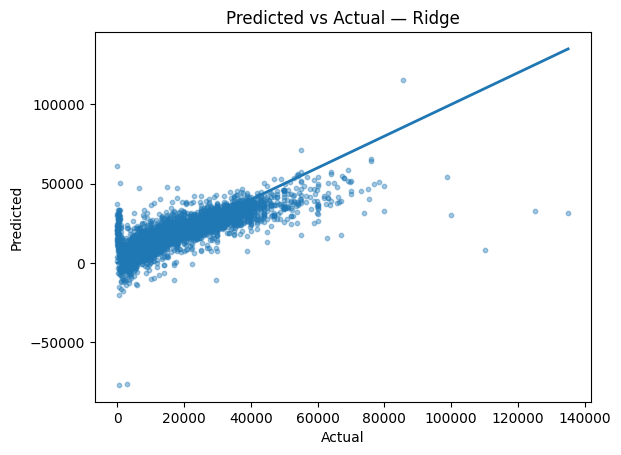

--- Lasso ---
[Lasso] MAE=5660.99 | RMSE=8884.93 | R2=0.614


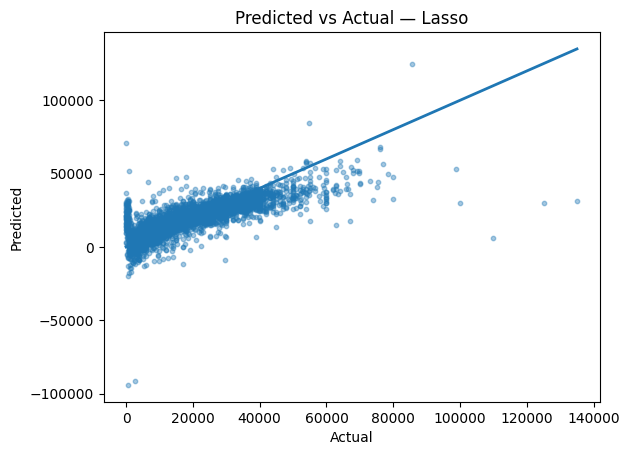

In [12]:
import numpy as np

def eval_regression(model, Xte, yte, name='model'):
    pred = model.predict(Xte)
    mae = mean_absolute_error(yte, pred)
    # Compatibilidad con versiones viejas de sklearn
    try:
        rmse = mean_squared_error(yte, pred, squared=False)
    except TypeError:
        rmse = np.sqrt(mean_squared_error(yte, pred))
    r2 = r2_score(yte, pred)

    print(f'[{name}] MAE={mae:.2f} | RMSE={rmse:.2f} | R2={r2:.3f}')

    # Gráfico
    plt.figure()
    plt.scatter(yte, pred, s=10, alpha=0.4)
    lo, hi = float(np.nanmin(yte)), float(np.nanmax(yte))
    plt.plot([lo, hi], [lo, hi], lw=2)
    plt.title(f'Predicted vs Actual — {name}')
    plt.xlabel('Actual'); plt.ylabel('Predicted')
    plt.show()

print('--- Ridge ---'); eval_regression(best_ridge, X_test_reg, y_test_reg, 'Ridge')
print('--- Lasso ---'); eval_regression(best_lasso, X_test_reg, y_test_reg, 'Lasso')


## Evaluación - Clasificación
Regresión logística

Accuracy=0.891 | Precision=0.893 | Recall=0.889 | F1=0.891 | ROC AUC=0.955


<Figure size 640x480 with 0 Axes>

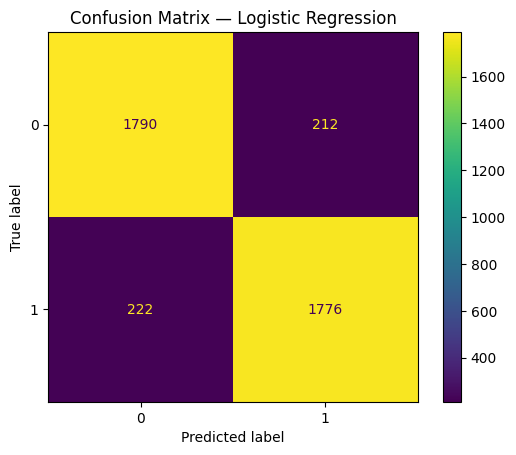

<Figure size 640x480 with 0 Axes>

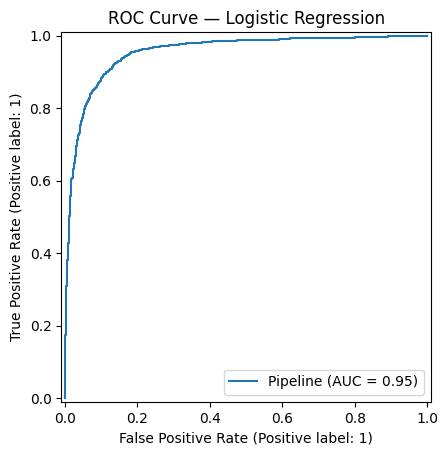

In [13]:
best_logreg = logreg_search.best_estimator_
y_pred = best_logreg.predict(X_test_clf)
y_prob = best_logreg.predict_proba(X_test_clf)[:,1]

acc = accuracy_score(y_test_clf, y_pred)
prec = precision_score(y_test_clf, y_pred, zero_division=0)
rec = recall_score(y_test_clf, y_pred, zero_division=0)
f1  = f1_score(y_test_clf, y_pred, zero_division=0)
auc = roc_auc_score(y_test_clf, y_prob)
print(f'Accuracy={acc:.3f} | Precision={prec:.3f} | Recall={rec:.3f} | F1={f1:.3f} | ROC AUC={auc:.3f}')

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_clf, y_pred))
plt.figure(); disp.plot(values_format='d'); plt.title('Confusion Matrix — Logistic Regression'); plt.show()

plt.figure(); RocCurveDisplay.from_estimator(best_logreg, X_test_clf, y_test_clf)
plt.title('ROC Curve — Logistic Regression'); plt.show()

## Preprocesamiento (Imputación de datos + OHE + MaxAbsScaler), Pipeline y GridSearchCV
KNN

In [ ]:
# === KNN Pipelines (mismos splits) 
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import MaxAbsScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold

# OneHotEncoder 
try:
    ohe_sparse = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
except TypeError:
    ohe_sparse = OneHotEncoder(handle_unknown='ignore', sparse=True)

cat_knn = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', ohe_sparse)
])

# MaxAbsScaler mantiene forma esparsa (mejor para KNN con OHE)
num_knn = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MaxAbsScaler())
])

# Fuerza salida esparsa si hay partes esparsas
preprocess_knn = ColumnTransformer(
    transformers=[
        ('cat', cat_knn, categorical_features),
        ('num', num_knn, numeric_features)
    ],
    sparse_threshold=1.0  # intenta devolver CSR
)


## Training - Regresión
Regresión KNN

In [15]:


# ------------------ REGRESIÓN KNN ------------------
knn_reg_pipe = Pipeline([
    ('preprocess', preprocess_knn),
    ('model', KNeighborsRegressor())
])

knn_reg_grid = {
    'model__n_neighbors': [5, 11, 21],
    'model__weights': ['uniform', 'distance'],
    'model__p': [1, 2]  # 1=Manhattan, 2=Euclid
}

cv_reg_knn = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
knn_reg_search = GridSearchCV(
    knn_reg_pipe, knn_reg_grid, cv=cv_reg_knn,
    scoring='neg_mean_absolute_error', n_jobs=1, verbose=2
)

print("Fitting KNN Regressor...")
knn_reg_search.fit(X_train_reg, y_train_reg)
print("Best KNN-REG:", knn_reg_search.best_params_, "=> MAE_cv:", -knn_reg_search.best_score_)



Fitting KNN Regressor...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END model__n_neighbors=5, model__p=1, model__weights=uniform; total time=   6.9s
[CV] END model__n_neighbors=5, model__p=1, model__weights=uniform; total time=   2.4s
[CV] END model__n_neighbors=5, model__p=1, model__weights=uniform; total time=   2.2s
[CV] END model__n_neighbors=5, model__p=1, model__weights=distance; total time=   1.5s
[CV] END model__n_neighbors=5, model__p=1, model__weights=distance; total time=   1.6s
[CV] END model__n_neighbors=5, model__p=1, model__weights=distance; total time=   1.7s
[CV] END model__n_neighbors=5, model__p=2, model__weights=uniform; total time=   3.1s
[CV] END model__n_neighbors=5, model__p=2, model__weights=uniform; total time=   2.9s
[CV] END model__n_neighbors=5, model__p=2, model__weights=uniform; total time=   2.9s
[CV] END model__n_neighbors=5, model__p=2, model__weights=distance; total time=   3.0s
[CV] END model__n_neighbors=5, model__p=2, model__

## Evaluación - Regresión 
KNN

[KNN Regressor] MAE=6358.98 | RMSE=11255.99 | R2=0.381


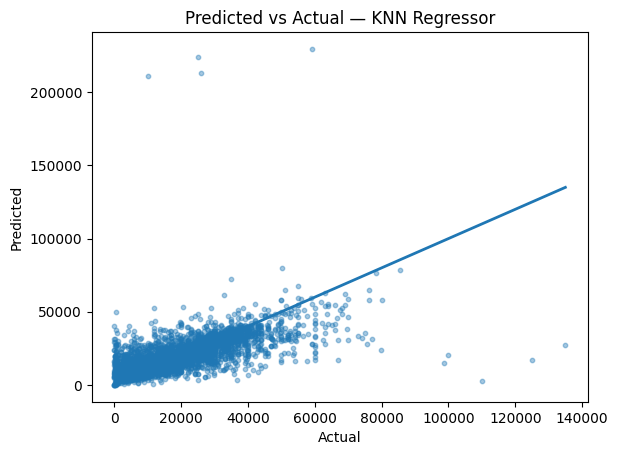

In [16]:
# ------------------ Evaluación Regresión (KNN) ------------------
best_knn_reg = knn_reg_search.best_estimator_
eval_regression(best_knn_reg, X_test_reg, y_test_reg, 'KNN Regressor')

## Training - Clasificación
KNN

In [17]:
# ------------------ CLASIFICACIÓN KNN ------------------
knn_clf_pipe = Pipeline([
    ('preprocess', preprocess_knn),
    ('model', KNeighborsClassifier())
])

knn_clf_grid = {
    'model__n_neighbors': [5, 11, 21],
    'model__weights': ['uniform', 'distance'],
    'model__p': [1, 2]
}

cv_clf_knn = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
knn_clf_search = GridSearchCV(
    knn_clf_pipe, knn_clf_grid, cv=cv_clf_knn,
    scoring='f1', n_jobs=1, verbose=2
)

print("Fitting KNN Classifier...")
knn_clf_search.fit(X_train_clf, y_train_clf)
print("Best KNN-CLF:", knn_clf_search.best_params_, "=> F1_cv:", knn_clf_search.best_score_)


Fitting KNN Classifier...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END model__n_neighbors=5, model__p=1, model__weights=uniform; total time=   2.4s
[CV] END model__n_neighbors=5, model__p=1, model__weights=uniform; total time=   2.4s
[CV] END model__n_neighbors=5, model__p=1, model__weights=uniform; total time=   2.3s
[CV] END model__n_neighbors=5, model__p=1, model__weights=distance; total time=   2.2s
[CV] END model__n_neighbors=5, model__p=1, model__weights=distance; total time=   1.5s
[CV] END model__n_neighbors=5, model__p=1, model__weights=distance; total time=   1.6s
[CV] END model__n_neighbors=5, model__p=2, model__weights=uniform; total time=   2.9s
[CV] END model__n_neighbors=5, model__p=2, model__weights=uniform; total time=   2.9s
[CV] END model__n_neighbors=5, model__p=2, model__weights=uniform; total time=   2.8s
[CV] END model__n_neighbors=5, model__p=2, model__weights=distance; total time=   2.9s
[CV] END model__n_neighbors=5, model__p=2, model_

## Evaluación - Clasificación
KNN

KNN-CLF → Accuracy=0.826 | Precision=0.829 | Recall=0.821 | F1=0.825 | ROC AUC=0.907


<Figure size 640x480 with 0 Axes>

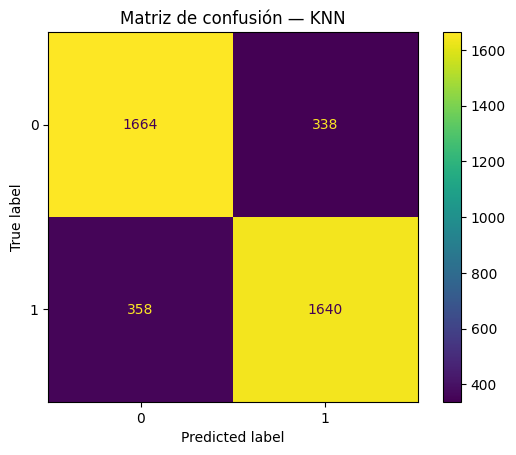

<Figure size 640x480 with 0 Axes>

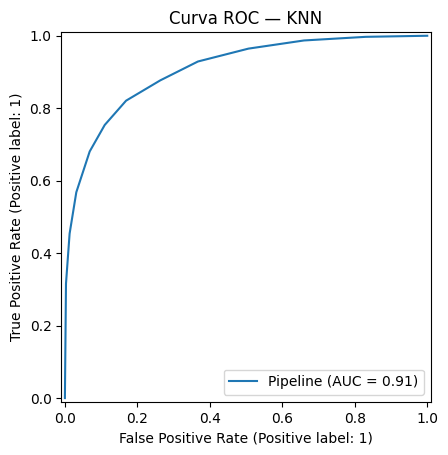

In [18]:
# Evaluación Clasificación (KNN)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)

best_knn_clf = knn_clf_search.best_estimator_
y_pred = best_knn_clf.predict(X_test_clf)
y_prob = best_knn_clf.predict_proba(X_test_clf)[:,1]

acc = accuracy_score(y_test_clf, y_pred)
prec = precision_score(y_test_clf, y_pred, zero_division=0)
rec = recall_score(y_test_clf, y_pred, zero_division=0)
f1  = f1_score(y_test_clf, y_pred, zero_division=0)
auc = roc_auc_score(y_test_clf, y_prob)
print(f'KNN-CLF → Accuracy={acc:.3f} | Precision={prec:.3f} | Recall={rec:.3f} | F1={f1:.3f} | ROC AUC={auc:.3f}')

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_clf, y_pred))
plt.figure(); disp.plot(values_format='d'); plt.title('Matriz de confusión — KNN'); plt.show()

plt.figure(); RocCurveDisplay.from_estimator(best_knn_clf, X_test_clf, y_test_clf)
plt.title('Curva ROC — KNN'); plt.show()


## Sección 4. Evaluación y Métricas

Esta sección genera **dos tablas** con métricas para los modelos entrenados:

- **Regresión:** Ridge, Lasso, KNN Regressor → MAE, RMSE, R²  
- **Clasificación:** Regresión Logística, KNN Classifier → Accuracy, Precision, Recall, F1, ROC AUC



In [19]:

import os, numpy as np, pandas as pd
from joblib import load
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

# ---------- Helpers ----------
def _rmse(y, yhat):
    try:
        return mean_squared_error(y, yhat, squared=False)
    except TypeError:
        return np.sqrt(mean_squared_error(y, yhat))

def eval_reg_metrics(model, X, y):
    yhat = model.predict(X)
    return {'MAE': float(mean_absolute_error(y, yhat)),
            'RMSE': float(_rmse(y, yhat)),
            'R2': float(r2_score(y, yhat))}

def eval_clf_metrics(model, X, y):
    yp = model.predict(X)
    try:
        ps = model.predict_proba(X)[:, 1]
        auc = float(roc_auc_score(y, ps))
    except Exception:
        auc = np.nan
    return {'Accuracy': float(accuracy_score(y, yp)),
            'Precision': float(precision_score(y, yp, zero_division=0)),
            'Recall': float(recall_score(y, yp, zero_division=0)),
            'F1': float(f1_score(y, yp, zero_division=0)),
            'ROC AUC': auc}

def get_model(best_var, search_var, joblib_path=None):
    # 1) variable best_* en memoria
    m = globals().get(best_var)
    if m is not None:
        return m
    # 2) best_estimator_ desde GridSearch
    if search_var in globals():
        try:
            return globals()[search_var].best_estimator_
        except Exception:
            pass
    # 3) archivo .joblib
    if joblib_path and os.path.exists(joblib_path):
        try:
            return load(joblib_path)
        except Exception:
            pass
    return None

# ---------- Recuperar modelos disponibles ----------
ridge   = get_model('best_ridge',  'ridge_search',  'ridge_price_model.joblib')
lasso   = get_model('best_lasso',  'lasso_search',  'lasso_price_model.joblib')
logreg  = get_model('best_logreg', 'logreg_search', 'logreg_demand_model.joblib')
knn_reg = get_model('best_knn_reg','knn_reg_search','knn_reg_model.joblib')
knn_clf = get_model('best_knn_clf','knn_clf_search','knn_clf_model.joblib')

# ---------- Verificar splits requeridos ----------
missing = [v for v in ["X_train_reg","y_train_reg","X_test_reg","y_test_reg",
                       "X_train_clf","y_train_clf","X_test_clf","y_test_clf"] if v not in globals()]
if missing:
    print("Faltan variables de split:", missing)
    print("Ejecuta la celda donde construyes los splits (train/test) y vuelve a correr esta celda.")
else:
    # ---------- Tabla: REGRESIÓN ----------
    reg_models = [(n,m) for n,m in [('Ridge',ridge),('Lasso',lasso),('KNN Regr',knn_reg)] if m is not None]
    reg_rows = []
    for name, m in reg_models:
        reg_rows.append({'Model': name, 'Split': 'Train', **eval_reg_metrics(m, X_train_reg, y_train_reg)})
        reg_rows.append({'Model': name, 'Split': 'Test',  **eval_reg_metrics(m, X_test_reg,  y_test_reg)})
    reg_results = pd.DataFrame(reg_rows).set_index(['Model','Split']).round(3) if reg_rows else pd.DataFrame()
    if not reg_results.empty:
        display(reg_results)
    else:
        print("No hay modelos de REGRESIÓN disponibles para resumir.")

    # ---------- Tabla: CLASIFICACIÓN ----------
    clf_models = [(n,m) for n,m in [('Logistic Reg',logreg),('KNN Class',knn_clf)] if m is not None]
    clf_rows = []
    for name, m in clf_models:
        clf_rows.append({'Model': name, 'Split': 'Train', **eval_clf_metrics(m, X_train_clf, y_train_clf)})
        clf_rows.append({'Model': name, 'Split': 'Test',  **eval_clf_metrics(m, X_test_clf,  y_test_clf)})
    clf_results = pd.DataFrame(clf_rows).set_index(['Model','Split']).round(3) if clf_rows else pd.DataFrame()
    if not clf_results.empty:
        display(clf_results)
    else:
        print("No hay modelos de CLASIFICACIÓN disponibles para resumir.")

    # ---------- (Opcional) Exportar ----------
    if not reg_results.empty:
        reg_results.to_csv('metrics_regression_train_test.csv')
    if not clf_results.empty:
        clf_results.to_csv('metrics_classification_train_test.csv')
    print("Archivos guardados: metrics_regression_train_test.csv, metrics_classification_train_test.csv")


MAE       RMSE     R2
Model    Split                            
Ridge    Train  4463.921  10903.947  0.650
         Test   5472.588   8626.067  0.637
Lasso    Train  5145.118  10602.146  0.670
         Test   5660.992   8884.932  0.614
KNN Regr Train  5293.393  13234.760  0.485
         Test   6358.976  11255.985  0.381

Accuracy  Precision  Recall     F1  ROC AUC
Model        Split                                             
Logistic Reg Train     0.912      0.912   0.911  0.912    0.966
             Test      0.892      0.893   0.889  0.891    0.955
KNN Class    Train     0.857      0.863   0.849  0.856    0.938
             Test      0.826      0.829   0.821  0.825    0.907

Archivos guardados (si hubo datos): metrics_regression_train_test.csv, metrics_classification_train_test.csv


En la comparación de modelos para predicción de precio, Ridge mostró la mejor generalización: en test obtuvo MAE=5 472.6, RMSE=8 626.1 y R²=0.637, con resultados muy consistentes respecto al train (R²=0.650). Lasso presentó un leve sobreajuste: aunque en train alcanzó R²=0.670, en test bajó a 0.614 (MAE=5 661.0; RMSE=8 884.9), lo que sugiere que la penalización L1 eliminó señales útiles. KNN Regressor quedó claramente por detrás (test R²=0.381, MAE=6 359.0; RMSE=11 256.0), probablemente afectado por la alta dimensionalidad tras el one-hot encoding. En consecuencia, se recomienda Ridge como modelo principal para precio y, para mejoras incrementales, evaluar objetivo logarítmico y reducción de cardinalidad en variables categóricas.

Por otro lado, en el caso de clasificación binaria, la Regresión Logística es claramente superior al KNN: en test logra Accuracy = 0.892, Precision = 0.893, Recall = 0.889, F1 = 0.891 y ROC-AUC = 0.955, con una caída moderada respecto a train (ROC-AUC = 0.966), lo que indica buena generalización. KNN queda por detrás (test: Accuracy = 0.826, F1 = 0.825, ROC-AUC = 0.907) y muestra menor capacidad de separación entre clases, consistente con la alta dimensionalidad tras el one-hot encoding. En consecuencia, se recomienda Regresión Logística como modelo principal para la demanda, dejando a KNN como referencia; si se requiere ajustar el balance precisión/recobrado, puede afinarse el umbral de decisión o calibrar probabilidades.

## Sección 5. Conclusiones

En conclusión se cumplió el objetivo: se construyeron pipelines reproducibles con imputación, escalado y one-hot encoding, y se ajustaron hiperparámetros mediante GridSearchCV con validación cruzada (estratificada en clasificación), evitando fuga de información. El flujo quedó modular, con separación clara entre preparación, entrenamiento y evaluación.

En síntesis de resultados, para regresión se obtuvo que el modelo Ridge generaliza mejor (MAE ≈ 5 472.6, RMSE ≈ 8 626.1, R² = 0.637), mientras que Lasso rinde un poco menos (R² = 0.614) y KNN queda rezagado (R² = 0.381) por la alta dimensionalidad inducida por el one-hot. En el caso de clasificación, la Regresión Logística supera a KNN (Accuracy = 0.892, F1 = 0.891, ROC-AUC = 0.955); por lo que se recomienda emplear Ridge para precio y Logística para demanda.

Para futuras iteraciones se recomienda que dado que el precio presenta una distribución marcadamente sesgada a la derecha, transformar el objetivo (p. ej., log1p(price)). , y también se reconoce que se utilizó CV = 3 por restricciones de memoria RAM; ampliar a CV = 5 podría ofrecer estimaciones más estables. 